# Load data

In [2]:
import torch
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.synchronize()
torch.backends.cudnn.benchmark = True


train_data_dir = r"../datasets/birds/train"
valid_data_dir = r"../datasets/birds/valid"
test_data_dir = r"../datasets/birds/test"

cuda


KeyError: 'CUDA_LAUNCH_BLOCKING'

In [3]:
from torch.utils.data import DataLoader
from core.dataloaders.images_dataset import ImageDataset
import torchvision.transforms.v2 as transforms

size = (128, 128)
# setting up transformation
transformation = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(size, antialias=True),
])

# augmentation for training
augmentation = transforms.Compose([
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize(size, antialias=True),
        # we can use random choice to apply random transformations, identify when using raw image
        # flip/rotations transforms
        transforms.RandomChoice([
            transforms.RandomVerticalFlip(p=1),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation(degrees=45),
            torch.nn.Identity(),            
        ]),
        # affine transforms
        transforms.RandomChoice([
            transforms.RandomAffine(degrees = 0, translate = (0., 0.2)),
            torch.nn.Identity(),            
        ]),
        # # color transforms
        # transforms.RandomChoice([
        #     transforms.RandomAdjustSharpness(sharpness_factor=2),
        #     transforms.RandomEqualize(p=1),
        #     transforms.RandomPosterize(bits=2, p=1),
        #     transforms.RandomInvert(p=1),
        #     torch.nn.Identity(),            
        # ]),
        # Gaussian noise
        transforms.RandomChoice([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.001, 0.1))          
        ]),

])

# creating dataset
train_dataset = ImageDataset(
    data_dir=train_data_dir,
    transform=augmentation
)
valid_dataset = ImageDataset(
    data_dir=valid_data_dir,
    transform=transformation
)


classes = train_dataset.classes
nb_classes = len(classes)
print(classes)
print("number of classes", nb_classes)

NameError: name 'train_data_dir' is not defined

training set 84635
valid set 2625
shapes:
torch.Size([256, 3, 128, 128])
torch.Size([256])


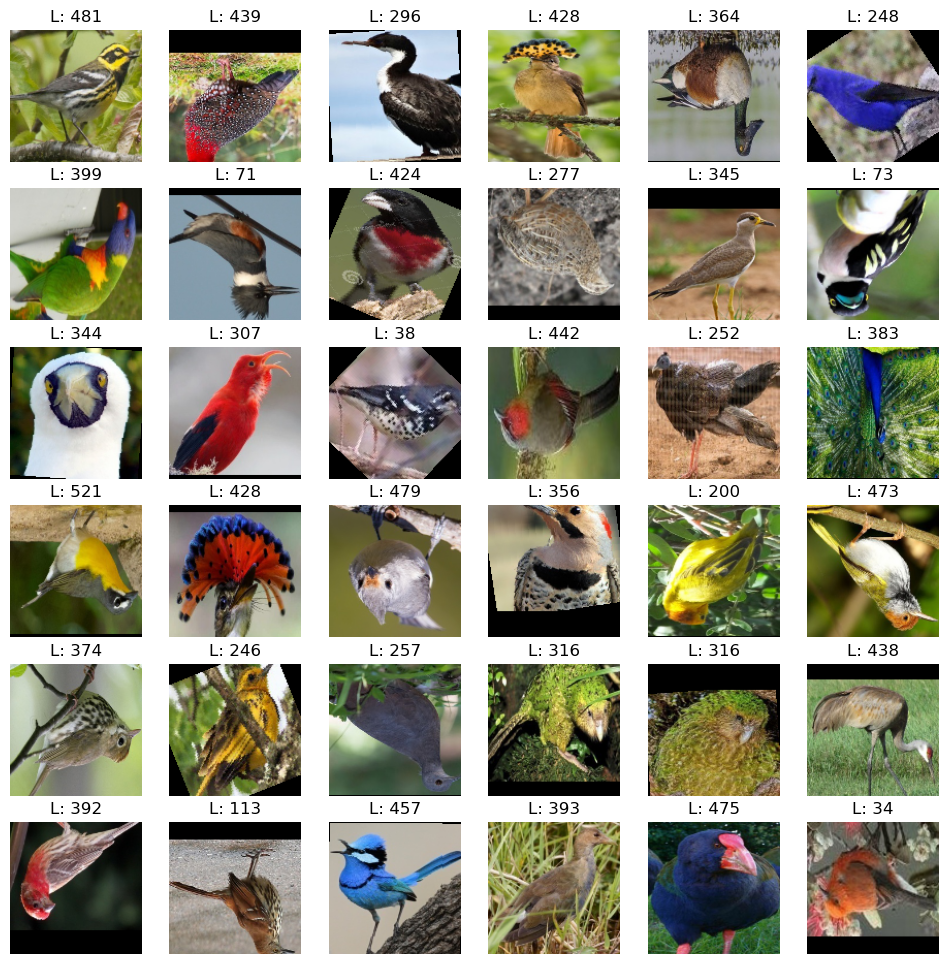

In [23]:
from shared_modules.display_engine import DisplayImages

# creating dataloader
workers = 8
prefetch = workers * 12
batch_size = 256
pin = False
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=workers,
                              prefetch_factor= prefetch,
                              persistent_workers=True,
                              pin_memory=pin)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=256,
                              shuffle=False,
                              num_workers=workers,
                              prefetch_factor= prefetch,
                              persistent_workers=True,
                              pin_memory=pin)

print("training set", len(train_dataloader.dataset))
print("valid set", len(valid_dataloader.dataset))


# iterating over the dataset
for _, (image, label) in enumerate(train_dataloader):
    print("shapes:")
    print(image.shape)
    print(label.shape)
    DisplayImages.display_image(image, label)
    break

# Model

In [24]:
from core.classifier_models.simplevit import SimpleVitClassifier
model = SimpleVitClassifier(image_size = (3, 128, 128),
                            patch_size = 16,
                            channels = 3,
                            num_classes = nb_classes,
                            depth=4,
                            heads=6,
                            mlp_dim= 512)

In [25]:
# create optimizer and loss function
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [26]:
# create wrapper
from core.wrappers.wrapper import Wrapper
classifier = Wrapper(model = model, optimizer= optimizer, criterion= criterion, device = "cuda")

In [27]:
from torchinfo import summary
input_size = image.shape
summary(model=classifier.model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
SimpleVitClassifier (SimpleVitClassifier)          [256, 3, 128, 128]   [256, 525]           --                   True
├─SimpleViT (base_model)                           [256, 3, 128, 128]   [256, 525]           --                   True
│    └─Sequential (to_patch_embedding)             [256, 3, 128, 128]   [256, 64, 256]       --                   True
│    │    └─Rearrange (0)                          [256, 3, 128, 128]   [256, 64, 768]       --                   --
│    │    └─LayerNorm (1)                          [256, 64, 768]       [256, 64, 768]       1,536                True
│    │    └─Linear (2)                             [256, 64, 768]       [256, 64, 256]       196,864              True
│    │    └─LayerNorm (3)                          [256, 64, 256]       [256, 64, 256]       512                  True
│    └─Transformer (transformer)             

In [28]:
# # model accuracy pre training
# predictions = classifier.predict_class(test_dataloader)
# print(predictions)

In [29]:
# loss, acc = classifier.evaluate(test_dataloader)
# print(loss, acc)
# for _, (image, label) in enumerate(test_dataloader):
#     class_pred = classifier.predict_class(image.to(device))
#     print(class_pred)
#     DisplayImages.display_image(image, label, class_pred, 6, 5)
#     break

In [ ]:
num_epochs = 100
classifier.fit(epochs=num_epochs, train_dataloader = train_dataloader, valid_dataloader=valid_dataloader)

Epochs::   0%|          | 0/100 [00:00<?, ?it/s]

| Epoch 1/100 | T-loss: 5.947 | V-loss: 5.543 |T-acc: 0.01 |V-acc: 0.03
| Epoch 2/100 | T-loss: 5.290 | V-loss: 4.944 |T-acc: 0.05 |V-acc: 0.08
| Epoch 3/100 | T-loss: 4.838 | V-loss: 4.531 |T-acc: 0.09 |V-acc: 0.11
| Epoch 4/100 | T-loss: 4.496 | V-loss: 4.220 |T-acc: 0.12 |V-acc: 0.15
| Epoch 5/100 | T-loss: 4.217 | V-loss: 3.948 |T-acc: 0.16 |V-acc: 0.19
| Epoch 6/100 | T-loss: 3.986 | V-loss: 3.702 |T-acc: 0.19 |V-acc: 0.24
| Epoch 7/100 | T-loss: 3.791 | V-loss: 3.469 |T-acc: 0.22 |V-acc: 0.28
| Epoch 8/100 | T-loss: 3.619 | V-loss: 3.327 |T-acc: 0.24 |V-acc: 0.30
| Epoch 9/100 | T-loss: 3.467 | V-loss: 3.186 |T-acc: 0.27 |V-acc: 0.31
| Epoch 10/100 | T-loss: 3.324 | V-loss: 3.030 |T-acc: 0.29 |V-acc: 0.35
| Epoch 11/100 | T-loss: 3.194 | V-loss: 2.914 |T-acc: 0.31 |V-acc: 0.36


In [ ]:
# model accuracy post training
test_dataset = BirdsDataset(
    data_dir=test_data_dir,
    transform=transformation
)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=workers,
                             prefetch_factor= prefetch,
                             persistent_workers=True,
                             pin_memory=pin)
print("test set", len(test_dataloader.dataset))

predictions = classifier.predict_class(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)
    break

In [ ]:
from shared_modules.display_engine import DisplayMetrics

DisplayMetrics.display_metrics(classifier.train_losses,
                               classifier.val_losses,
                               classifier.train_acc,
                               classifier.val_acc)

In [ ]:
from shared_modules.display_engine import DisplayMetrics

labels = []
class_preds = []
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    labels.extend(label.numpy())
    class_preds.extend(class_pred)

DisplayMetrics.confusion_matrix(labels, class_preds, (20, 20))
DisplayMetrics.prediction_distribution(labels, class_preds, (20, 20))